In [194]:
dut.disconnect()

Serial port disconnected.


In [145]:
dut.ground_PIC()

DAC initialized to a span from -5 V to 5 V


In [241]:
dut.reset_chip()
dut.reset_dpe()

In [193]:
dut.power_off()

In [168]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM6', 9600, timeout=1)
dut.connect(ser)


In [130]:
dut.power_on()

Calibrate all 12 ADCs on A0

In [88]:
volt_in = np.arange(0.5, 4.5, 0.1)
volt_out_list = []
for addr_fifo in range(12):
    data = dut.calibrate_adc(volt_in, addr_fifo=addr_fifo )
    volt_out_list.append( [dut.adc2volt(d) for d in data] )
    

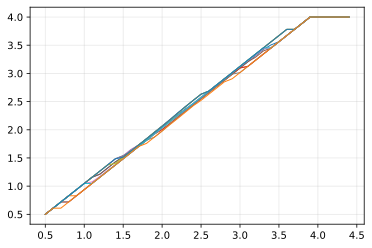

In [89]:
plt.grid(True, alpha=0.3)
for volt_out in volt_out_list:
    plt.plot(volt_in, volt_out, linewidth=1)

In [176]:
def _cal_tia(col):
    drv.gpio_pin_reset(*PIC_PINS['READ_DPE'])
    drv.gpio_pin_reset(*PIC_PINS['READ_BIT'])
    dut.pads_defaults()

    dut.scan_tia( BitArray('0b1100000100'*96).bytes )

    dut.load_vectors_rows_to_zero()
    dut.load_vectors_cols_to_zero()

#     col = 2
    row = 8
    data = dut.data_generate_sparse([row,col])
    dut.load_vectors(data=data, array=2)

    dut.reset_dpe()
    # dut.py_logic_analyzer()

    #%%
    dut.reset_dpe()

    drv.gpio_pin_set(*PIC_PINS['WRITE_SEL_EXT'])
    drv.gpio_pin_set(*PIC_PINS['DPE_EXT_OVERRIDE_EN'])                 
    time.sleep(5e-6)   
    drv.gpio_nforce_safe_write(0b111)
    time.sleep(5e-6)        # delay(t_cal_start), min = 2TCK
    drv.gpio_pin_set(*PIC_PINS['COL_WRITE_CONNECT'])
    time.sleep(5e-6)        # delay(t_opamp), min = 500ns
    drv.gpio_pin_set(*PIC_PINS['CONNECT_TIA'])
    #drv.gpio_pin_set(*PIC_PINS['DPE_EXT_SH'])

    #%%
    time.sleep(0.2)
    # Before setting this, we're using an external current source to apply to the board!
    drv.gpio_pin_set(*PIC_PINS['DPE_EXT_SH'])

    #%%
    n_adc = 0

    n_adc, n_ch = dut.which_fifo( [2, row, col] )
    data = dut.download_fifo( n_adc )

    return dut.adc2volt(data[n_ch]), [bin(d) for d in data]

In [191]:
vals = []
dut.dac_set('P_VREF_TIA', 0.5)

for c in range(64):
    print(f'{c}', end=',')
    vals.append( _cal_tia(c)[0] )

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,

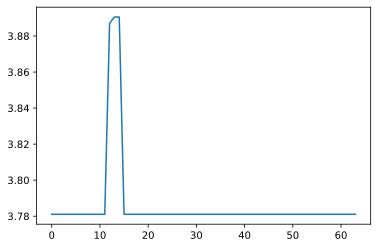

In [192]:
plt.plot(range(64), vals)

In [153]:
_cal_tia(1)

(0.5,
 ['0b100000000000',
  '0b100000000000',
  '0b100000000000',
  '0b100000100000',
  '0b100000000000',
  '0b100000000000',
  '0b100000000000',
  '0b100000000000',
  '0b100000000000',
  '0b100000000000',
  '0b100000000000',
  '0b100000000000',
  '0b100000000000',
  '0b100000000000',
  '0b100000000000',
  '0b100000000000'])

In [164]:
[fifo, channel]=dut.which_fifo([2, 31, 2])
print(fifo, channel)

0 6


In [147]:
data = dut.data_generate_sparse([31, 3])
print([bin(d) for d in data])

['0b1000000000000000', '0b0', '0b0', '0b0', '0b0', '0b100000000000000', '0b0', '0b0']
